## Word embedding : Glove

In this notebook, we will use the Glove model to compute Word Embedding on our tweets dataset, before training a classification model on the lower-dimension vector space.

We will compare this pre-trained cloud model to the baseline model from 1_baseline.ipynb.

### Load project modules and data

We will use basic python packages, and the library package with 300 dimensions of Glove model.

In [1]:
# Import custom helper libraries
import os
import sys
import sys, os, re, csv, codecs
import pickle

# Maths modules
import numpy as np
import pandas as pd
from numpy import exp
from numpy.core.fromnumeric import repeat, shape  # noqa: F401,W0611
from scipy.stats import f_oneway

# Viz modules
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
%matplotlib inline

# Render for export
import plotly.io as pio
pio.renderers.default = "notebook"
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)  
import plotly.figure_factory as ff

#Sklearn modules
from sklearn import metrics
from sklearn.metrics import (ConfusionMatrixDisplay,PrecisionRecallDisplay,RocCurveDisplay,)
from sklearn.metrics import (confusion_matrix, roc_auc_score, average_precision_score, classification_report)
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score)
from sklearn.base import ClassifierMixin, is_classifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# System modules
import random
import contractions
import re
import time
from collections import Counter
from collections import defaultdict
from unidecode import unidecode
import logging
from typing import Callable, Dict, List, Optional, Tuple, Union
import gc
from random import shuffle
import itertools

# ML modules
from tqdm import tqdm
tqdm.pandas()

# NLTK modules
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Keras modules
import keras
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, BatchNormalization, TimeDistributed, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
# from keras.layers import (LSTM, Embedding, BatchNormalization, Dense, TimeDistributed, Dropout, Bidirectional, Flatten, GlobalMaxPool1D)
# from keras.optimizers import Adam

# Tensoflow modules
from tensorflow.keras.callbacks import EarlyStopping

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import session_info
session_info.show()

### Load data
Let's download the data from the [Kaggle - Sentiment140 dataset with 1.6 million tweets competition](https://www.kaggle.com/datasets/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv).

In [2]:
# Load data from CSV
df = pd.read_csv(r"C:\\Users\\ezequ\\proyectos\\openclassrooms\\Projet_7\\data\\raw\\sentiment140_16000_tweets.csv",
                 names=["target", "text"], encoding='latin-1')

# Drop useless raw
df = df.iloc[1: , :]

df.describe(include="all")

,target,text
count,16000,16000
unique,2,15987
top,NEGATIVE,isPlayer Has Died! Sorry
freq,8000,5


In [5]:
df

,target,text
1,NEGATIVE,@xnausikaax oh no! where did u order from? tha...
2,NEGATIVE,A great hard training weekend is over. a coup...
3,NEGATIVE,"Right, off to work Only 5 hours to go until I..."
4,NEGATIVE,I am craving for japanese food
5,NEGATIVE,Jean Michel Jarre concert tomorrow gotta work...
...,...,...
15996,POSITIVE,my video is about mileys latest movie &quot;th...
15997,POSITIVE,Had a great birthday yesterday....peaceful and...
15998,POSITIVE,Just had lovely lunch with girls from work sit...
15999,POSITIVE,my cousin @PinkMordeno and i are watching the ...


### Text pre-processing
Before we can train our model, we need to pre-process the text data. We will tokeinze the text using Keras and vectorize the documents (list of tokens) with the word embedding model FastText.

#### Text tokenization

During the tokenization process, we apply the following pre-processing steps:

* remove special characters
* remove stop words
* lemmatize words
* transform to lowercase

In [6]:
def text_cleaning(text, ponct, only_letters, numbers):
    text = text.lower()
    text = unidecode(text)
    ponctuation = "[^!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]"
    number = "[^0-9]"
    letters = "[^a-zA-Z ]"
    if ponct == 1:
        text = re.sub(ponctuation, '', text)
    if only_letters == 1:
        text = re.sub(letters, '', text)
    if numbers == 1:
        text = re.sub(number, '', text)
    return text

In [7]:
# Let's put the text in lower case.
df["new_text"] = df["text"].str.lower()

In [8]:
# Let's apply the function to write the whole contractions.
df['new_text'] = df.progress_apply(lambda x: contractions.fix(x['text']),axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 38564.48it/s]


In [9]:
# Let's remove the punctuation.
df['new_text'] = df.progress_apply(lambda x: text_cleaning(x['text'], 0, 1, 0),axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 53121.92it/s]


In [10]:
# We can separate the text into word lists => each word unit is a tokens
df['words'] = df.progress_apply(lambda x: word_tokenize(x['new_text']),axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:02<00:00, 7399.72it/s]


In [11]:
# Let's count the number of words per comment
df['nb_words'] = df.progress_apply(lambda x: len(x['words']),axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 71941.15it/s]


### Cleaning Stopwords

Let's try to use the nltk library, in order to remove the words that don't bring any information.

In [12]:
nltk.download('stopwords')
sw_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ezequ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
keep_words = []
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

new_sw_nltk.extend(['th','pm', 's', 'er', 'paris', 'rst', 'st', 'am', 'us'])

These words do not bring any meaning regarding the feelings in the sentences. In other words, they are so-called empty words for our project.

In [14]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
cleaning = df['new_text'].str.replace(pat, '')
df['new_words'] = cleaning.progress_apply(lambda x: nltk.word_tokenize(x))
df['new_text'] = cleaning

C:\Users\ezequ\AppData\Local\Temp\ipykernel_6680\2045429064.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 8172.59it/s]


Let's create a function.

In [15]:
# The process of classifying words into their parts of speech and labeling 
# them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. 

def word_pos_tagger(list_words):
    pos_tagged_text = nltk.pos_tag(list_words)
    return pos_tagged_text

Let's concatenate the words of the different documents because we want to see what is the nature of the words in our corpus in order to keep only the useful types.

In [16]:
all_reviews = df["new_text"].str.cat(sep=' ')
description_words = word_pos_tagger(nltk.word_tokenize(all_reviews))

In [17]:
list_keep = []
list_excl = ['IN', 'DT', 'CD', 'CC', 'RP', 'WDT', 'EX', 'MD', 'NNP', 'WDT', 'UH', 'WRB', 
'WP', 'WP$', 'PDT', 'PRP$', 'EX', 'POS', 'SYM', 'TO', 'NNPS']
for word, tag in description_words:
    if tag not in list_excl:
        list_keep.append(tag)

In [18]:
df["text_tokens_pos_tagged"] =  df["new_text"].progress_apply(lambda x: nltk.word_tokenize(x))

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 9606.46it/s]


In [19]:
df["text_tokens_pos_tagged"] =  df["text_tokens_pos_tagged"].progress_apply(lambda x: nltk.pos_tag(x))

100%|███████████████████████████████████████████████████████████████████████████| 16000/16000 [00:18<00:00, 858.35it/s]


In [20]:
list_nouns = ["NN", "NNS"]
df["words_subjects"] =  df["text_tokens_pos_tagged"].progress_apply(lambda x: [y for y, tag in x if tag in list_nouns])

100%|████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 205593.06it/s]


In [21]:
# The join() method takes all items in an iterable and joins them into one string.
df["words_subjects"] =  df["words_subjects"].progress_apply(lambda x: " ".join(x))

100%|████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 517491.88it/s]


It would also be interesting to **keep the root of the words** after filtering on the names.
There are two methods:

    - Stemming removes suffixes and prefixes from words without taking the context into consideration. 
    - Lemmatization method considers the context and converts the word into its "meaningful" base form.

In [22]:
def stemming_text(word):
    stemmer = SnowballStemmer(language='english')
    return stemmer.stem(word)
 
def lemmatize_text(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    return lemmatizer.lemmatize(text)

In [23]:
df["words_subjects_st"] = df["words_subjects"].progress_apply(lambda x: stemming_text(x))

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:00<00:00, 41135.55it/s]


In [24]:
df["words_subjects_lem"] = df["words_subjects"].progress_apply(lambda x: lemmatize_text(x))

100%|██████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 9504.03it/s]


In [25]:
df["words_token_lem"] = df["words_subjects_lem"].progress_apply(lambda x: word_tokenize(x))

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 12844.51it/s]


In [26]:
df["words_token_st"] = df["words_subjects_st"].progress_apply(lambda x: word_tokenize(x))

100%|█████████████████████████████████████████████████████████████████████████| 16000/16000 [00:01<00:00, 13064.15it/s]


### Target encoding

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,text,new_text,words,nb_words,new_words,text_tokens_pos_tagged,words_subjects,words_subjects_st,words_subjects_lem,words_token_lem,words_token_st,target_encoded
1,NEGATIVE,@xnausikaax oh no! where did u order from? tha...,xnausikaax oh u order thats horrible,"[xnausikaax, oh, no, where, did, u, order, fro...",10,"[xnausikaax, oh, u, order, thats, horrible]","[(xnausikaax, JJ), (oh, MD), (u, JJ), (order, ...",order thats,order that,order thats,"[order, thats]","[order, that]",0
2,NEGATIVE,A great hard training weekend is over. a coup...,great hard training weekend couple days ...,"[a, great, hard, training, weekend, is, over, ...",25,"[great, hard, training, weekend, couple, days,...","[(great, JJ), (hard, JJ), (training, NN), (wee...",training weekend couple days lets computer time,training weekend couple days lets computer tim,training weekend couple days lets computer time,"[training, weekend, couple, days, lets, comput...","[training, weekend, couple, days, lets, comput...",0
3,NEGATIVE,"Right, off to work Only 5 hours to go until I...",right work hours go im free xd,"[right, off, to, work, only, hours, to, go, un...",12,"[right, work, hours, go, im, free, xd]","[(right, JJ), (work, NN), (hours, NNS), (go, V...",work hours xd,work hours xd,work hours xd,"[work, hours, xd]","[work, hours, xd]",0
4,NEGATIVE,I am craving for japanese food,craving japanese food,"[i, am, craving, for, japanese, food]",6,"[craving, japanese, food]","[(craving, VBG), (japanese, JJ), (food, NN)]",food,food,food,[food],[food],0
5,NEGATIVE,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work...,"[jean, michel, jarre, concert, tomorrow, got, ...",10,"[jean, michel, jarre, concert, tomorrow, got, ...","[(jean, JJ), (michel, NN), (jarre, NN), (conce...",michel jarre concert tomorrow work,michel jarre concert tomorrow work,michel jarre concert tomorrow work,"[michel, jarre, concert, tomorrow, work]","[michel, jarre, concert, tomorrow, work]",0


### Vectorization
#### Word embedding:
    - Glove
    - Word2vec
    - Fasttext
Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.    

We will test to diferent techniques to keep the root of eack token. First place, lammelization, and then Steamming. We will try the same model and parameters for both aproaches, to see if there is an impact on the metrics scoring. 

### Lemmatization

In [28]:
list_sentences_train = df["words_subjects_lem"].values
list_sentences_test = df["words_subjects_lem"].values

In [29]:
list_classes = ["target_encoded"]
y = df[list_classes].values

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [30]:
# Calculate the length of our vocabulary
from keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(list_sentences_train)

In [31]:
word_tokenizer

In [32]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)  + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 18877


In [33]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [34]:
longest_train = max(list_sentences_train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(list_sentences_train), length_long_sentence, padding='post')
# test_sentences = pad_sequences(
#     embed(list_sentences_train), 
#     length_long_sentence,
#     padding='post'
# )

In [35]:
length_long_sentence

65

In [36]:
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [37]:
X_t

array([[    0,     0,     0, ...,     0,   542,    13],
       [    0,     0,     0, ...,   211,   149,     5],
       [    0,     0,     0, ...,     4,    40,   421],
       ...,
       [    0,     0,     0, ...,   137, 18874,  4026],
       [    0,     0,     0, ...,  3471,  1058,  4635],
       [    0,     0,     0, ...,   399,    87, 18876]])

The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix.

In [38]:
## ADAPTACION PARA CREAR DF CON RESULTS

def loadEmbeddingMatrix(typeToLoad):
    """
    Args:
        typeToLoad: word_embedding type
    Returns:
        Embedding_matrix.
    """
    
    
#load different embedding file from Kaggle depending on which embedding 
#matrix we are going to experiment with
    if(typeToLoad=="glove"):
        EMBEDDING_FILE= ('C://Users//ezequ//proyectos//openclassrooms//Projet_7//data//raw//glove.6B.300d.txt')
        embed_size = 300
    elif(typeToLoad=="word2vec"):
#             w2v_model = Word2Vec.load('C://Users//ezequ//proyectos//openclassrooms//Projet_7//data//raw//GoogleNews-vectors-negative300.bin',binary=True,limit=100000)
#             model = w2v_model.wv
        model = word2vec.KeyedVectors.load_word2vec_format('C:\Program Files (x86)\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin',binary=True,limit=100000)
        #model = KeyedVectors.load_word2vec_format('C:\Program Files (x86)\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin',binary=True,limit=100000)
        #word2vec_model =  gensim.models.KeyedVectors.load_word2vec_format('C:\Program Files (x86)\GoogleNews-vectors-negative300\GoogleNews-vectors-negative300.bin', encoding="utf8", binary=True)
        embed_size = 300
    elif(typeToLoad=="fasttext"):
        EMBEDDING_FILE= ('C://Users//ezequ//proyectos//openclassrooms//Projet_7//data//raw//wiki-news-300d-1M.vec')
        embed_size = 300

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
        #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        f = open(EMBEDDING_FILE, encoding="utf8")
        for line in f:
            #split up line into an indexed array
            values = line.split()
            #first index is word
            word = values[0]
            #store the rest of the values in the array as a new array
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs #50 dimensions
        f.close()
        print('Loaded %s word vectors.' % len(embeddings_index))
    else:
        embeddings_index = dict()
        for word in model.key_to_index:
            embeddings_index[word] = model.word_vec(word)
        print('Loaded %s word vectors.' % len(embeddings_index))

    gc.collect()
#We get the mean and standard deviation of the embedding weights so that we could maintain the 
#same statistics for the rest of our own random generated weights. 
    all_embs = np.hstack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(tokenizer.word_index)
#We are going to set the embedding size to the pretrained dimension as we are replicating it.
#the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

#With the newly created embedding matrix, we'll fill it up with the words that we have in both 
#our own dictionary and loaded pretrained embedding. 
    EMBEDDING_DIM = 300
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    embeddedCount = 0
    for word, i in word_index.items():
        i-=1
        #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        #and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')

    del(embeddings_index)
    gc.collect()
    

    #finally, return the embedding matrix
    return embedding_matrix
    

The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix

### glove

Let's move on and load our first embeddings from glove

In [39]:
embedding_matrix_glove = loadEmbeddingMatrix('glove')

Loaded 400000 word vectors.
total embedded: 9448 common words


In [40]:
embedding_matrix_glove.shape

(18877, 300)

With the embedding weights, we can proceed to build a LSTM layer. The whole architecture is pretty much the same as the previous one I have done in the earlier kernel here, except that I have turned the LSTM into a bidirectional one, and added a dropout factor to it.

We start off with defining our input layer. By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [41]:
maxlen=300
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we use the "weights" parameter to indicate the use of the pretrained embedding weights we have loaded and the "trainable" parameter to tell Keras not to retrain the embedding layer.

In [42]:
# x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
EMBEDDING_DIM = 300

x_glove = Embedding(vocab_size,
          EMBEDDING_DIM,
          weights=[embedding_matrix_glove],
          input_length=length_long_sentence,
          trainable=False)(inp)


#### Model LSTM

In [43]:
# Split data into train and test sets
# set aside 20% of train and test data for evaluation
# Manually shuffle the data to avoind val_acc and loss_acc with insignificant values
np.random.shuffle(X_t)
np.random.shuffle(y)

X_train, X_test, y_train, y_test = train_test_split(X_t, y,
    test_size=0.2, shuffle = shuffle, random_state = 42)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.1, random_state= 42) # 0.25 x 0.8 = 0.2

In [44]:
# Print the sets data shapes
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (11520, 300)
X_test shape: (3200, 300)
y_train shape: (11520, 1)
y_test shape: (3200, 1)
X_val shape: (1280, 300)
y_val shape: (1280, 1)


### LSTM model with glove matrix embedding

In [45]:
def lstm_1():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix_glove.shape[0], 
        output_dim=embedding_matrix_glove.shape[1], 
        weights = [embedding_matrix_glove], 
        input_length=maxlen
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = lstm_1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          5663100   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 130)         190320    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 130)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 130)              520       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 130)               0         
                                                        

In [46]:
x = x_glove

In [47]:
x

<KerasTensor: shape=(None, 300, 300) dtype=float32 (created by layer 'embedding')>

### Evaluation of the model

In [48]:
results = pd.DataFrame(
        columns=[
                "model",  # Model name
                "precision_score",  # 
                "recall_score",  # 
                "f1_score",  # 
                "accuracy_score",  # List of inertia values of clusters
                #"time",  # Time spent for training and prediction
        ]

    )
def process_results(classification_report):
    
    results = pd.DataFrame(
        columns=[
                "model",  # Model name
                "precision_score",  # 
                "recall_score",  # 
                "f1_score",  # 
                "accuracy_score",  # List of inertia values of clusters
                #"time",  # Time spent for training and prediction
        ]

    )

    # Compute the model results
    result = {
        "model": str(model),
        "precision_score": precision_score, 
        "recall_score": recall_score,
        "f1_score": f1_score, 
        "accuracy_score": accuracy,
        "loss": loss, 
    }
    
# Append model results to the results dataframe
    results = results.append(result, ignore_index=True)
    
    return results


In [49]:
results

,model,precision_score,recall_score,f1_score,accuracy_score


In [50]:
batch_size = 32
epochs = 10
# hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
hist = model.fit(
    X_train,
    y_train, 
    batch_size=batch_size, 
    epochs=epochs,  
    verbose='auto',
    callbacks=[EarlyStopping(monitor="val_loss", patience=3),],
    validation_data= [X_val, y_val], 
    workers=4,
    use_multiprocessing=True,)

Epoch 1/10
360/360 [==============================] - 156s 426ms/step - loss: 0.7130 - accuracy: 0.5002 - val_loss: 0.6987 - val_accuracy: 0.4758
Epoch 2/10
360/360 [==============================] - 153s 426ms/step - loss: 0.6996 - accuracy: 0.5098 - val_loss: 0.6971 - val_accuracy: 0.5031
Epoch 3/10
360/360 [==============================] - 154s 428ms/step - loss: 0.6923 - accuracy: 0.5320 - val_loss: 0.7543 - val_accuracy: 0.4922
Epoch 4/10
360/360 [==============================] - 158s 440ms/step - loss: 0.6789 - accuracy: 0.5693 - val_loss: 0.7091 - val_accuracy: 0.5133
Epoch 5/10
360/360 [==============================] - 153s 425ms/step - loss: 0.6523 - accuracy: 0.6073 - val_loss: 0.7628 - val_accuracy: 0.5078


In [51]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

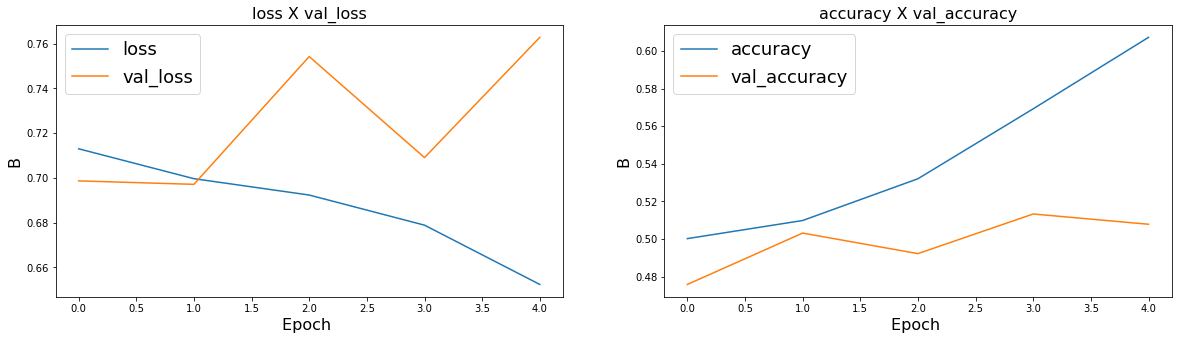

In [52]:
plot(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [53]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

100/100 [==============================] - 9s 93ms/step - loss: 0.7686 - accuracy: 0.5088
Loss: 0.7685794830322266
Accuracy: 0.5087500214576721


In [54]:
x_axes = ['NEGATIVE', 'POSITIVE']
y_axes = ['POSITIVE', 'NEGATIVE']  

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = {},
                      yaxis = {}
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

              precision    recall  f1-score   support

    NEGATIVE       0.51      0.89      0.65       644
    POSITIVE       0.52      0.12      0.19       636

    accuracy                           0.51      1280
   macro avg       0.51      0.51      0.42      1280
weighted avg       0.51      0.51      0.42      1280

ROC AUC score :  0.505
Average Precision score :  0.5


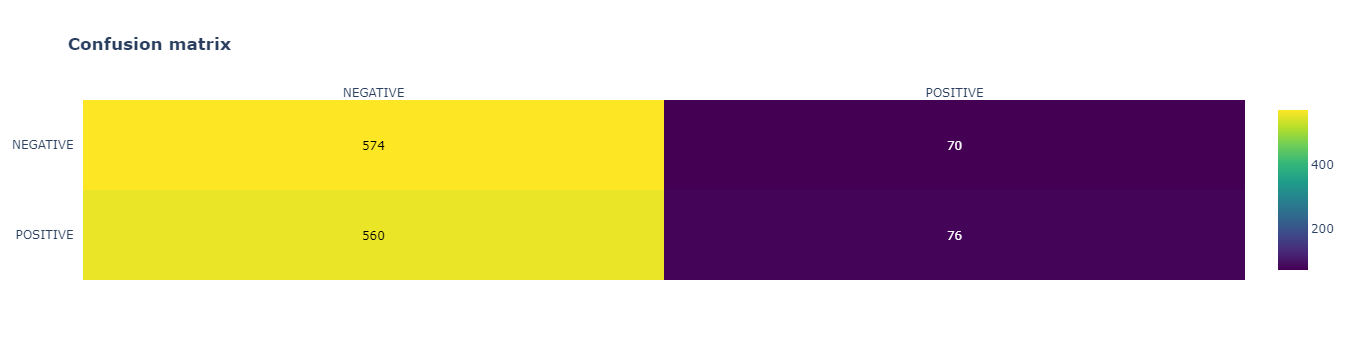

In [55]:
y_preds = (model.predict(X_val) > 0.5).astype("int32")
# show_metrics(y_preds, y_val)
target_names = ['NEGATIVE', 'POSITIVE']
print(classification_report(y_val, y_preds, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(y_val, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_val, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_val, y_preds))

              precision    recall  f1-score   support

    NEGATIVE       0.51      0.89      0.65      1625
    POSITIVE       0.50      0.12      0.19      1575

    accuracy                           0.51      3200
   macro avg       0.51      0.50      0.42      3200
weighted avg       0.51      0.51      0.42      3200

ROC AUC score :  0.503
Average Precision score :  0.494


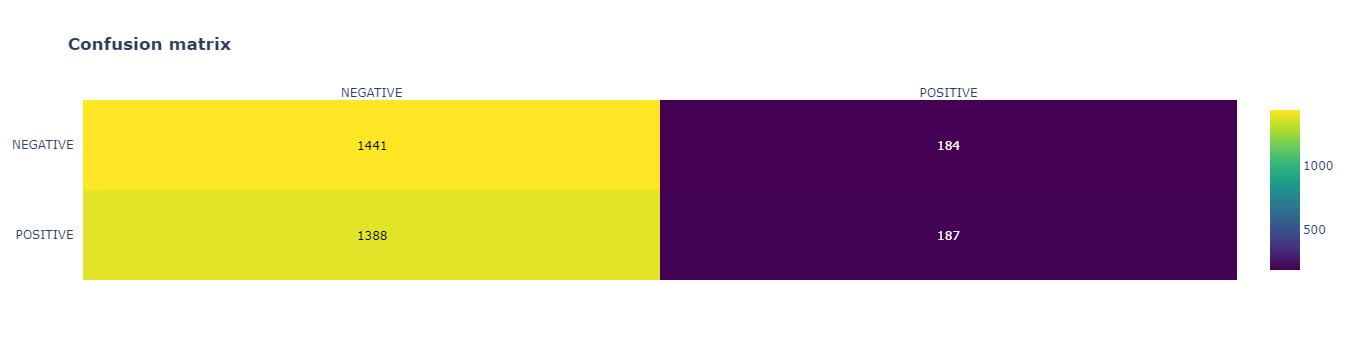

In [56]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
# conf_matrix(metrics.confusion_matrix(y_test, y_preds))
class_report = classification_report(y_test, y_preds, target_names=target_names)
print(class_report)
print("ROC AUC score : ", round(roc_auc_score(y_test, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_test, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

### Steamming approach

Now we will use the workflow to test if the Steamming technique to keep the roots of the words

In [57]:
embed_size=0

In [58]:
list_classes = ["target_encoded"]
y = df[list_classes].values

In [59]:
list_sentences_train = df["words_subjects_st"].values
list_sentences_test = df["words_subjects_st"].values

In [60]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list_sentences_train)
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [61]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(list_sentences_train)

In [62]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)  + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 19204


In [63]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [64]:
longest_train = max(list_sentences_train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(list_sentences_train), length_long_sentence, padding='post')

In [65]:
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix.

The function would return a new embedding matrix that has the loaded weights from the pretrained embeddings for the common words we have, and randomly initialized numbers that has the same mean and standard deviation for the rest of the weights in this matrix

### glove

Let's move on and load our first embeddings from glove

In [66]:
embedding_matrix_glove = loadEmbeddingMatrix('glove')

Loaded 400000 word vectors.
total embedded: 9203 common words


In [67]:
embedding_matrix_glove.shape

(19204, 300)

With the embedding weights, we can proceed to build a LSTM layer. The whole architecture is pretty much the same as the previous one I have done in the earlier kernel here, except that I have turned the LSTM into a bidirectional one, and added a dropout factor to it.

We start off with defining our input layer. By indicating an empty space after comma, we are telling Keras to infer the number automatically.

In [68]:
maxlen=300
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

Next, we pass it to our Embedding layer, where we use the "weights" parameter to indicate the use of the pretrained embedding weights we have loaded and the "trainable" parameter to tell Keras not to retrain the embedding layer.

In [69]:
EMBEDDING_DIM = 300

x_glove = Embedding(vocab_size,
          EMBEDDING_DIM,
          weights=[embedding_matrix_glove],
          input_length=length_long_sentence,
          trainable=False)(inp)


### Evaluation of the model

In [70]:
batch_size = 32
epochs = 10
# hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs,  validation_data= [X_val, y_val], callbacks=[EarlyStopping(monitor="val_loss", patience=3),], workers=4,use_multiprocessing=True,)

Epoch 1/10
360/360 [==============================] - 156s 433ms/step - loss: 0.6010 - accuracy: 0.6719 - val_loss: 0.8752 - val_accuracy: 0.5055
Epoch 2/10
360/360 [==============================] - 168s 467ms/step - loss: 0.5262 - accuracy: 0.7352 - val_loss: 0.8778 - val_accuracy: 0.4945
Epoch 3/10
360/360 [==============================] - 154s 428ms/step - loss: 0.4410 - accuracy: 0.7843 - val_loss: 0.9797 - val_accuracy: 0.4906
Epoch 4/10
360/360 [==============================] - 162s 451ms/step - loss: 0.3793 - accuracy: 0.8217 - val_loss: 1.2681 - val_accuracy: 0.5063


In [71]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

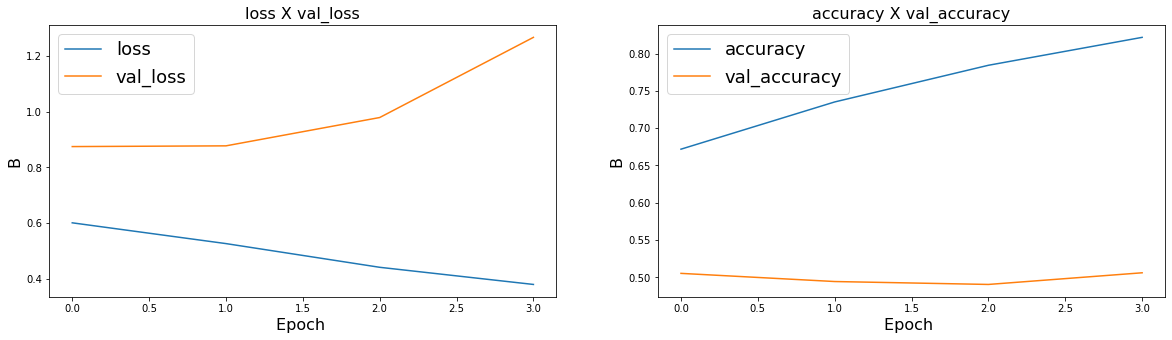

In [72]:
plot(hist, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [73]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

100/100 [==============================] - 9s 92ms/step - loss: 1.2253 - accuracy: 0.4950
Loss: 1.2252891063690186
Accuracy: 0.4950000047683716


In [74]:
x_axes = ['NEGATIVE', 'POSITIVE']
y_axes = ['POSITIVE', 'NEGATIVE']  

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = {},
                      yaxis = {}
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

              precision    recall  f1-score   support

    NEGATIVE       0.52      0.22      0.31       644
    POSITIVE       0.50      0.80      0.62       636

    accuracy                           0.51      1280
   macro avg       0.51      0.51      0.46      1280
weighted avg       0.51      0.51      0.46      1280

ROC AUC score :  0.508
Average Precision score :  0.501


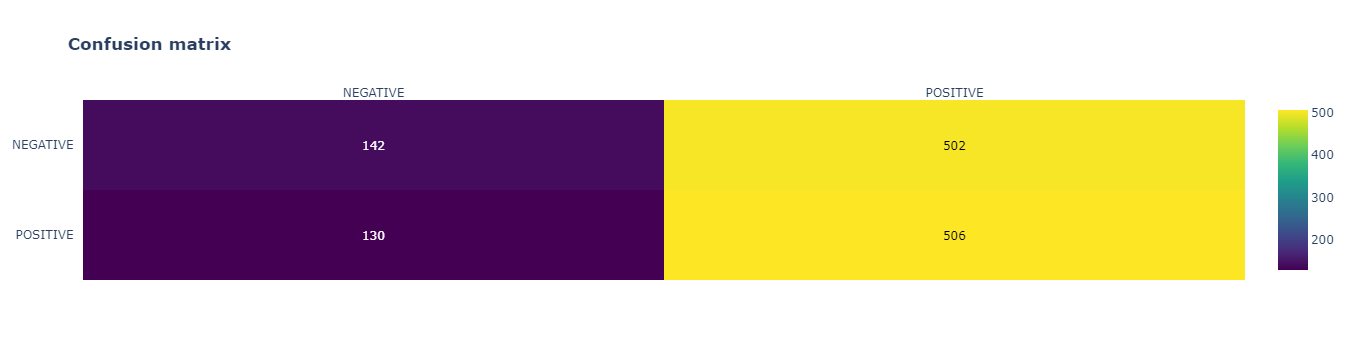

In [75]:
y_preds = (model.predict(X_val) > 0.5).astype("int32")
# show_metrics(y_preds, y_val)
target_names = ['NEGATIVE', 'POSITIVE']
print(classification_report(y_val, y_preds, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(y_val, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_val, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_val, y_preds))

              precision    recall  f1-score   support

    NEGATIVE       0.51      0.22      0.31      1625
    POSITIVE       0.49      0.78      0.60      1575

    accuracy                           0.49      3200
   macro avg       0.50      0.50      0.46      3200
weighted avg       0.50      0.49      0.45      3200

ROC AUC score :  0.499
Average Precision score :  0.492


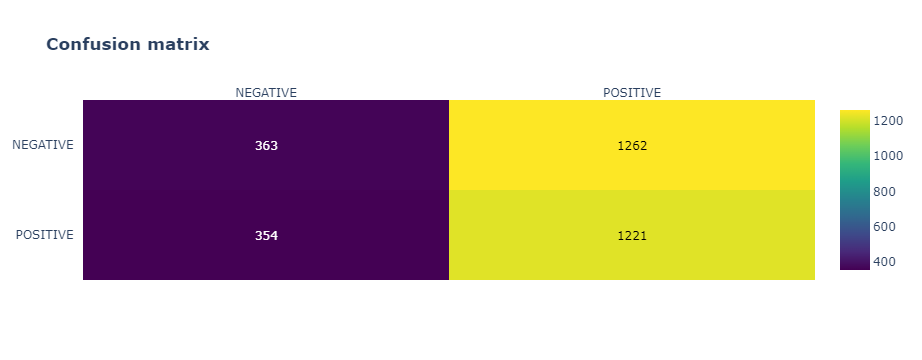

In [76]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")
# conf_matrix(metrics.confusion_matrix(y_test, y_preds))
print(classification_report(y_test, y_preds, target_names=target_names))
print("ROC AUC score : ", round(roc_auc_score(y_test, y_preds), 3))
print("Average Precision score : ", round(average_precision_score(y_test, y_preds), 3),)
conf_matrix(metrics.confusion_matrix(y_test, y_preds))

### Conclusions


The performances on the dataset are slightly worst than our baseline model :

**Lemm + Glove + LSTM**

* Average Precision = 0.525 (baseline = 0.65 , -19.3%)
* ROC AUC = 0.5 (baseline = 0.66 , -23.1%)

**Steamm + Glove + LSTM**

* Average Precision = 0.506 (baseline = 0.65 , -23.3%)
* ROC AUC = 0.496 (baseline = 0.66 , -24.8%)
 
Our model is also biased towards the POSITIVE.